In [77]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [78]:
!nvidia-smi

Sun Apr 23 14:23:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    31W /  70W |   1033MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [79]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import networkx as nx
from tqdm.notebook import trange, tqdm
from torch import nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [81]:
plt.style.use('ggplot')

In [82]:
train_df = pd.read_csv('/content/gdrive/MyDrive/hw2_data/dataset1/train.csv')
print(train_df.describe())
print(train_df.head())
print()
print(f"There are {train_df[train_df['label']==1]['id'].count()} edges in training graph.")
print(f"There are {train_df['to'].unique().max()} vertices in the training graph.")

                to         from        label
count  8686.000000  8686.000000  8686.000000
mean   1350.108335  1363.374511     0.497813
std     774.818411   789.594499     0.500024
min       0.000000     1.000000     0.000000
25%     672.000000   673.000000     0.000000
50%    1374.500000  1374.000000     0.000000
75%    2031.000000  2056.750000     1.000000
max    2707.000000  2707.000000     1.000000
       id    to  from  label
0  E10311  2399  2339      0
1  E10255  2397  1144      1
2  E10667   854  1726      0
3   E9395   872   702      0
4   E5926  2450  1312      1

There are 4324 edges in training graph.
There are 2707 vertices in the training graph.


In [83]:
with open("/content/gdrive/MyDrive/hw2_data/dataset1/content.csv", 'r') as f:
    lines = f.readlines()
    attributes = [ [] for _ in range(len(lines)) ]
    for line in lines:
        line = line.split()
        line = list( map(int, line) )
        attributes[line[0]].extend(line[1:])

attributes = np.array(attributes)
print(f"There are {attributes.shape[0]} nodes")
print(f"There are {attributes.shape[1]} attributes per node")

There are 2708 nodes
There are 1433 attributes per node


In [84]:
class KFold:

    def __init__(self, graph, edges, no_edges, k=5):
        self.k = k
        # since positive and negative samples are not in same size
        self.fold_size_pos = len(edges) // k
        self.fold_size_neg = len(no_edges) // k
        # create the full graph without removing any edges
        self.origin_graph = graph

        # shuffle the positive and negative edges
        random.shuffle(edges)
        random.shuffle(no_edges)
        self.pos_edges = edges
        self.neg_edges = no_edges


    def get_fold(self, fold):
        if fold >= self.k:
            print("Out of the boundary!!")
        else:
            subgraph = self.origin_graph.copy()
            subgraph.remove_edges_from(
                self.pos_edges[fold*self.fold_size_pos: (fold+1)*self.fold_size_pos]
            )
            pos_samples = self.pos_edges[fold*self.fold_size_pos: (fold+1)*self.fold_size_pos]
            neg_samples = self.neg_edges[fold*self.fold_size_neg: (fold+1)*self.fold_size_neg]

            return subgraph, pos_samples, neg_samples
            
    def get_k(self):
        return self.k

In [85]:
class LinkData:
    def __init__(self, X, y, batch_size='whole'):
        if batch_size == 'whole':
            self.batch_size = len(y)
        else:
            self.batch_size = batch_size
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)
        self.total_size = len(y)
    def __getitem__(self, i):
        if i >= self.__len__():
            raise IndexError('End')
        return self.X[i*self.batch_size: (i+1)*self.batch_size], self.y[i*self.batch_size: (i+1)*self.batch_size]
    def __len__(self):
        return int(self.total_size/self.batch_size)
    def get_size(self):
        return self.total_size

In [86]:
class GCNEncoder(nn.Module):
    def __init__(self, channel_in, channel_hidden, channel_out, hidden_num=1):
        super().__init__()
        gcns = []
        self.acts = nn.ModuleList( [ nn.LeakyReLU() for _ in range(hidden_num) ] )
        gcns.append( GCNConv(channel_in, channel_hidden) )
        for _ in range(hidden_num-1):
            gcns.append( GCNConv(channel_hidden, channel_hidden) ) 
        gcns.append( GCNConv(channel_hidden, channel_out) )
        self.gcns = nn.ModuleList(gcns)
        self.hidden_num = hidden_num

    def forward(self, x, edge_idx):
        for i in range(self.hidden_num):
            x = self.gcns[i](x, edge_idx)
            x = self.acts[i](x)
        x = self.gcns[-1](x, edge_idx)
        return x

class E2ELinkModel(nn.Module):
    def __init__(self, channel_in, channel_hidden, channel_out, hidden_num=3):
        super().__init__()
        self.encoder = GCNEncoder(channel_in, channel_hidden, channel_out, hidden_num)
        self.sigmoid = nn.Sigmoid()
        """for mlp
        self.mlp = nn.Linear(channel_out, 1)
        """
        

    def forward(self, graph_data, node1, node2):
        z = self.encoder(graph_data.x, graph_data.edge_index)
        x = self.predict_from_embed(z, node1, node2)
        return x
    def get_embed(self, graph_data):
        return self.encoder(graph_data.x, graph_data.edge_index)

    def predict_from_embed(self, z, node1, node2):
        
        z = z[node1] * z[node2]
        x = z.sum(dim=-1)
        """for mlp
        x = self.mlp(z).flatten()
        """ 
        return x
        
    def predict_proba_from_embed(self, z, node1, node2):
        x = self.predict_from_embed(z, node1, node2)
        return self.sigmoid(x)

In [87]:
def train(model, graph_data, train_loader, param, val_loader=None, with_val=False):

    device = param['device']
   
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=param['lr'])
    model.train()
    loss_fn = nn.BCEWithLogitsLoss()
    for epoch in range(param['epochs']):
        total_loss = 0
        #print(f"=========================== {epoch+1} ===========================")
        for X, y_true in train_loader:
            # Zero your gradients for every batch!
            optimizer.zero_grad()
            X, y_true = X.to(device), y_true.to(device)
            graph_data = graph_data.to(device)
            y_pred = model(graph_data, X[:,0], X[:,1])
            loss = loss_fn(y_pred, y_true.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        #print(f"Training loss ====> {total_loss/train_loader.get_size():.6f}")
    if with_val:
        acc, ap = val(model, graph_data, val_loader, param)
        return acc, ap
    else:
        return None, None

def val(model, graph_data, loader, param):

    device = param['device']
    model.to(device)
    model.eval()
    total_acc, total_ap = 0, 0
    with torch.no_grad():
        graph_data = graph_data.to(device)
        embedding = model.get_embed(graph_data)
        for X, y_true in loader:
            X, y_true = X.to(device), y_true.to(device)
            
            y_pred = model.predict_proba_from_embed(embedding, X[:, 0], X[:, 1])
            
            ap = average_precision_score(
                y_true.detach().cpu().numpy().reshape(-1),
                y_pred.detach().cpu().numpy().reshape(-1)
            )
            acc = roc_auc_score(
                y_true.detach().cpu().numpy().reshape(-1),
                y_pred.detach().cpu().numpy().reshape(-1)
            )

            total_ap += ap
            total_acc += acc

    avg_acc, avg_ap = total_acc, total_ap
    
    print(f"Validation acc ====> {avg_acc*100:.4f}%")
    print(f"Validation ap ====> {avg_ap*100:.4f}%")
    
    return avg_acc, avg_ap

In [88]:
def cross_validation(kfold, **param):

    LOSS = []
    ACC = []
    AP = []
    
    for fold in trange(kfold.get_k()):
        print()
        print(f"=========================== Fold: {fold+1} ===========================")
        # validation on different folds
        graph, pos_samples, neg_samples = kfold.get_fold(fold)
        
        print("Preparing Data....")
        # split pos_samples and neg_samples to training classifier and validating (3:1)
        train_pos_samples, valid_pos_samples = train_test_split(pos_samples, test_size=.25)
        train_neg_samples, valid_neg_samples = train_test_split(neg_samples, test_size=.25)

        train_samples = train_pos_samples + train_neg_samples
        train_labels = np.array(
            [1 for _ in range(len(train_pos_samples))] + [0 for _ in range(len(train_neg_samples))]
        )
        valid_samples = valid_pos_samples + valid_neg_samples
        valid_labels = np.array(
            [1 for _ in range(len(valid_pos_samples))] + [0 for _ in range(len(valid_neg_samples))]
        )
        graph_data = Data(
            x=torch.tensor(attributes, dtype=torch.float32), 
            edge_index=torch.tensor(edge2index(graph.edges), dtype=torch.long)
        )

        train_loader = LinkData(train_samples, train_labels, batch_size=param['batch_size'])
        val_loader = LinkData(valid_samples, valid_labels, batch_size='whole')
        model = E2ELinkModel(
            CH_IN, CH_HIDDEN, CH_OUT, HIDDEN_NUM
        )

        acc, ap = train(model, graph_data, train_loader, param, val_loader, with_val=True)

        ACC.append(acc)
        AP.append(ap)

    return ACC, AP

def edge2index(edges): # convert networkx edges to pyg edge_indices
    edge_idx = [[], []]
    for v1, v2 in edges:
        edge_idx[0].append(v1)
        edge_idx[1].append(v2)
        edge_idx[0].append(v2)
        edge_idx[1].append(v1)
    return edge_idx

In [89]:
def construct_graph(edges):
    graph = nx.Graph()
    graph.add_edges_from(edges)
    return graph

In [90]:
CH_IN = attributes.shape[1]
CH_HIDDEN = 256
CH_OUT = 128
HIDDEN_NUM = 1
param = {
    'lr': 1e-5, 'batch_size': 64, 'epochs': 100,
    'device': 'cuda:0' if torch.cuda.is_available() else 'cpu'
}

In [91]:
edges = ( train_df[train_df['label']==1][['to', 'from']].apply(tuple, axis=1) ).tolist()
no_edges = ( train_df[train_df['label']==0][['to', 'from']].apply(tuple, axis=1) ).tolist()
graph = construct_graph(edges)
kfold = KFold(graph, edges, no_edges, k=5)

In [92]:
acc_result, ap_result = cross_validation(kfold, **param)

  0%|          | 0/5 [00:00<?, ?it/s]


=========================== Fold: 1 ===========================
Preparing Data....
Validation acc ====> 91.9576%
Validation ap ====> 91.6088%

=========================== Fold: 2 ===========================
Preparing Data....
Validation acc ====> 88.6595%
Validation ap ====> 88.9884%

=========================== Fold: 3 ===========================
Preparing Data....
Validation acc ====> 92.3165%
Validation ap ====> 92.7103%

=========================== Fold: 4 ===========================
Preparing Data....
Validation acc ====> 87.6996%
Validation ap ====> 86.8188%

=========================== Fold: 5 ===========================
Preparing Data....
Validation acc ====> 91.8238%
Validation ap ====> 92.5297%


In [93]:
print(acc_result)
print(ap_result)
best_fold = np.argmax(acc_result)
print("Best Fold: {best_fold}")

[0.9195761128100578, 0.8865953109072374, 0.9231651376146789, 0.8769962623173633, 0.9182381923207611]
[0.9160882057208595, 0.8898843264869263, 0.9271032588208117, 0.8681882346078776, 0.925296663334147]
Best Fold: {best_fold}


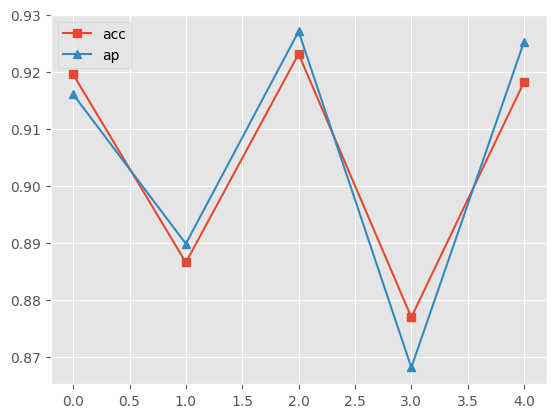

In [94]:
plt.plot(range(5), acc_result, 's-', label='acc')
plt.plot(range(5), ap_result, '^-', label='ap')
plt.legend()
plt.show()

In [95]:
model = E2ELinkModel(
    CH_IN, CH_HIDDEN, CH_OUT, HIDDEN_NUM
)
graph, pos_samples, neg_samples = kfold.get_fold(best_fold)

train_samples = pos_samples + neg_samples
train_labels = np.array(
    [1 for _ in range(len(pos_samples))] + [0 for _ in range(len(neg_samples))]
)
loader = LinkData(train_samples, train_labels, batch_size=param['batch_size'])
graph_data = Data(
    x=torch.tensor(attributes, dtype=torch.float32), 
    edge_index=torch.tensor(edge2index(graph.edges), dtype=torch.long)
)
train(model, graph_data, loader, param)

(None, None)

In [96]:
# load test data
test_df = pd.read_csv("/content/gdrive/MyDrive/hw2_data/dataset1/test.csv")
# testing
print("Start testing...")
valid_samples = torch.tensor( ( test_df[['to', 'from']].apply(tuple, axis=1) ).tolist() , dtype=torch.long)
model.to('cuda:0')
z = model.get_embed(graph_data)
outputs = model.predict_proba_from_embed(z, valid_samples[:, 0], valid_samples[:, 1])
test_df.drop(columns=['to', 'from'])
test_df['prob'] = pd.Series(outputs.detach().cpu().numpy())
# store the csv
test_df.to_csv('/content/gdrive/MyDrive/hw2_data/dataset1/upload.csv', index=False)
print("finish testing")

Start testing...
finish testing
